# Using Flash Attention 2 ⚡

In this notebook we will compare [Flash Attention 2](https://github.com/Dao-AILab/flash-attention) with the [`torch.nn.functional.scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) function and a simple implementation.

### Installation

Follow instructions here:
https://github.com/Dao-AILab/flash-attention

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [2]:
import torch
import torch.utils.benchmark as benchmark


# Simple implementation in PyTorch
from rl4co.models.nn.attention import scaled_dot_product_attention_simple
# PyTorch official implementation of FlashAttention 1
from torch.nn.functional import scaled_dot_product_attention
# FlashAttention 2
from rl4co.models.nn.flash_attention import scaled_dot_product_attention_flash_attn

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer
from rl4co.models.common.constructive.autoregressive import GraphAttentionEncoder



/home/botu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing differences with simple tensors

In [3]:
bs, head, length, d = 64, 8, 512, 128

query = torch.rand(bs, head, length, d, dtype=torch.float16, device="cuda")
key = torch.rand(bs, head, length, d, dtype=torch.float16, device="cuda")
value = torch.rand(bs, head, length, d, dtype=torch.float16, device="cuda")

# Simple implementation in PyTorch
out_simple = scaled_dot_product_attention_simple(query, key, value)

# PyTorch official implementation of FlashAttention 1
out_pytorch = scaled_dot_product_attention(query, key, value)

# FlashAttention 2
out_flash_attn = scaled_dot_product_attention_flash_attn(query, key, value)


print(torch.allclose(out_simple, out_pytorch, atol=1e-3))
print(torch.allclose(out_flash_attn, out_pytorch, atol=1e-3))

print(torch.max(torch.abs(out_simple - out_pytorch)), torch.mean(torch.abs(out_simple - out_pytorch)))
print(torch.max(torch.abs(out_flash_attn - out_pytorch)), torch.mean(torch.abs(out_flash_attn - out_pytorch)))


True
True
tensor(0.0005, device='cuda:0', dtype=torch.float16) tensor(1.2159e-05, device='cuda:0', dtype=torch.float16)
tensor(0.0005, device='cuda:0', dtype=torch.float16) tensor(6.3777e-06, device='cuda:0', dtype=torch.float16)


## Testing Graph Attention Encoders with Flash Attention 2

In [4]:
env = TSPEnv(generator_params=dict(num_loc=1000))

num_heads = 8
embed_dim = 128
num_layers = 3
enc_simple = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                            sdpa_fn=scaled_dot_product_attention_simple)

enc_fa1 = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                            sdpa_fn=scaled_dot_product_attention)

enc_fa2 = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                            sdpa_fn=scaled_dot_product_attention_flash_attn)

# Flash Attention supports only FP16 and BFloat16
enc_simple.to("cuda").half()
enc_fa1.to("cuda").half()
enc_fa2.to("cuda").half()

GraphAttentionEncoder(
  (init_embedding): TSPInitEmbedding(
    (init_embed): Linear(in_features=2, out_features=128, bias=True)
  )
  (net): GraphAttentionNetwork(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention(
            (Wqkv): Linear(in_features=128, out_features=384, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [5]:
def build_models(num_heads=8, embed_dim=128, num_layers=3):
    enc_simple = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                                sdpa_fn=scaled_dot_product_attention_simple)

    enc_fa1 = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                                sdpa_fn=scaled_dot_product_attention)

    enc_fa2 = GraphAttentionEncoder(env, num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers,
                                sdpa_fn=scaled_dot_product_attention_flash_attn)

    # Flash Attention supports only FP16 and BFloat16
    enc_simple.to("cuda").half()
    enc_fa1.to("cuda").half()
    enc_fa2.to("cuda").half()
    return enc_simple, enc_fa1, enc_fa2

In [6]:
threads = 32
sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

times_simple = []
times_fa1 = []
times_fa2 = []

# for embed_dim in [64, 128, 256]:
for embed_dim in [128]:
    # Get models
    enc_simple, enc_fa1, enc_fa2 = build_models(embed_dim=embed_dim)

    for problem_size in sizes:

        with torch.no_grad():
            # initial data
            env = TSPEnv(generator_params=dict(num_loc=problem_size))
            td_init = env.reset(batch_size=[2])
            # set dtype to float16
            td_init = td_init.to(dest="cuda", dtype=torch.float16)

            t_simple = benchmark.Timer(
                setup='x = td_init',
                stmt='encode(x)',
                globals={'td_init': td_init, 'encode': enc_simple},
                num_threads=threads)

            t_fa1 = benchmark.Timer(
                setup='x = td_init',
                stmt='encode(x)',
                globals={'td_init': td_init, 'encode': enc_fa1},
                num_threads=threads)
            
            t_fa2 = benchmark.Timer(
                setup='x = td_init',
                stmt='encode(x)',
                globals={'td_init': td_init, 'encode': enc_fa2},
                num_threads=threads)
            
            times_simple.append(torch.tensor(t_simple.blocked_autorange().times).mean())
            times_fa2.append(torch.tensor(t_fa2.blocked_autorange().times).mean())
            times_fa1.append(torch.tensor(t_fa1.blocked_autorange().times).mean())

            print(f"Times for problem size {problem_size}: Simple {times_simple[-1]*1e3:.3f}, FA1 {times_fa1[-1]*1e3:.3f}, FA2 {times_fa2[-1]*1e3:.3f}")

    # eliminate cache
    torch.cuda.empty_cache()

Times for problem size 10: Simple 0.633, FA1 0.511, FA2 0.554
Times for problem size 20: Simple 0.646, FA1 0.535, FA2 0.565
Times for problem size 50: Simple 0.663, FA1 0.547, FA2 0.580
Times for problem size 100: Simple 0.664, FA1 0.547, FA2 0.580
Times for problem size 200: Simple 0.670, FA1 0.509, FA2 0.585
Times for problem size 500: Simple 0.669, FA1 0.512, FA2 0.582
Times for problem size 1000: Simple 1.088, FA1 0.555, FA2 0.609
Times for problem size 2000: Simple 3.626, FA1 1.292, FA2 0.790
Times for problem size 5000: Simple 20.332, FA1 5.748, FA2 2.943
Times for problem size 10000: Simple 80.337, FA1 20.701, FA2 10.230


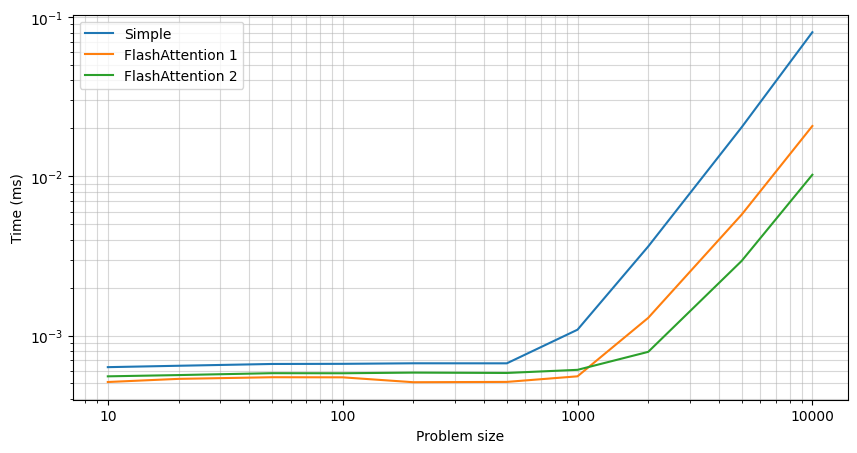

In [7]:
# Plot results
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sizes, times_simple, label="Simple")
ax.plot(sizes, times_fa1, label="FlashAttention 1")
ax.plot(sizes, times_fa2, label="FlashAttention 2")

# fancy grid
ax.grid(True, which="both", ls="-", alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Problem size")
ax.set_ylabel("Time (ms)")
ax.legend()

# Instead of 10^1, 10^2... show nuber
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))

plt.show()

Using FlashAttention can speed up inference even at small context lengths (number of nodes in the graph). Difference can be of several times for large graphs between different implementations!